# Mapping the GLS approach of https://github.com/kundajelab/coessentiality to our gene expression data: 

In [19]:
import pandas as pd
import os
import numpy as np
from scipy.special import stdtr

import matplotlib.pyplot as plt
from sklearn.cluster import SpectralBiclustering
import re

import numpy as np, pandas as pd, subprocess
from statsmodels.stats.multitest import fdrcorrection

from scipy.sparse import csr_matrix, save_npz
import sys
sys.path.append('/home/ajinich/Documents/repos/coessentiality/')
import diffmap as dm
import anndata as adata

import scanpy as sc

import hvplot.pandas

In [20]:
import tqdm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import holoviews as hv 
import bokeh.io
import bokeh.plotting
import colorcet as cc

import seaborn as sns
colors = sns.color_palette('tab10')

In [5]:
def choose_k(data, max_clus):
    "Helper function to choose the number of clusters for KMeans."
    
    k_tests = np.arange(2, max_clus)
    wcss = []
    silhouettes_ = []
    for k in tqdm.tqdm(k_tests): 
        clustering = KMeans(k, random_state= 42).fit(data)
        wcss.append(clustering.inertia_)
        silhouettes_.append(silhouette_score(data, clustering.predict(data)))
    
    
    return wcss, silhouettes_

### Loading data: 

Should we work with the normalized or non-normalized data? 

In [345]:
file_in = '/home/ajinich/Dropbox/KyuRhee/unknown_function/unknown_redox/data/expression/colombo/tb_adata_v2.h5ad'
# file_in = '/home/ajinich/Dropbox/KyuRhee/unknown_function/unknown_redox/data/expression/colombo/tb_adata_v1.h5ad'


In [346]:
a_GE_Tn = adata.read_h5ad(file_in)
print('mixed GE + TnSeq dataset size:', a_GE_Tn.shape)
a_GE_Tn.var.data_type.value_counts()

mixed GE + TnSeq dataset size: (4016, 1226)


/home/ajinich/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


expression    1098
tnseq_bin       64
tnseq_fc        64
Name: data_type, dtype: int64

In [347]:
ind_GE = a_GE_Tn.var[a_GE_Tn.var.data_type == 'expression'].index.tolist()
ind_GE = [int(i) for i in ind_GE]
mat_data = a_GE_Tn.X[:, ind_GE]
mat_data.shape

(4016, 1098)

In [348]:
print('Are there any NaNs?', np.any(np.isnan(mat_data)))

Are there any NaNs? False


### Warp screen data and intercept based on covariance of screens


Is the data already normalized?

In [349]:
arr_mean = mat_data.mean(0)
arr_std = mat_data.std(0)
arr_mean.shape, arr_std.shape

((1098,), (1098,))

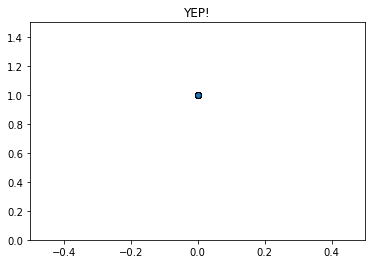

In [351]:
plt.scatter(arr_mean, arr_std, edgecolors='k')
plt.xlim(-0.5,0.5)
plt.ylim(0, 1.5)
ttl = plt.title('YEP!')

In [352]:
cov_mat = np.cov(mat_data.T)
inv_mat = np.linalg.inv(cov_mat)
cov_mat.shape

(1098, 1098)

I couldn't get the Cholesky decomposition.

Debug this by exploring the covariance matrix: 

In [354]:
def max_off_diagonal(mat, th):
    # I want to find the maximum value of the off-diagonal elements of the covariance matrix: 
    ij_off_diag = np.where(~np.eye(mat.shape[0],dtype=bool))
    i_OD = ij_off_diag[0]
    j_OD = ij_off_diag[1]
    
    ind_th = [kk for kk in range(len(i_OD)) if np.abs(mat[i_OD[kk], j_OD[kk]])>=th and (i_OD[kk]<j_OD[kk])]
    
    ij_th = [i_OD[ind_th], j_OD[ind_th]]
    return ij_th

In [355]:
th = 0.99
ij_th = max_off_diagonal(cov_mat, th)
print('off-diagonal indices with large correlations:')
ij_th

off-diagonal indices with large correlations:


[array([508, 561]), array([510, 567])]

Test Cholesky decomposition after dropping these rows/columns: 

In [356]:
mat_data_d = np.delete(mat_data, ij_th[0], 1)
cov_mat_d = np.cov(mat_data_d.T)
print('new shape of covariance matrix:', cov_mat_d.shape)

th = 0.99
print('off-diagonal large correlations?')
max_off_diagonal(cov_mat_d, th)

new shape of covariance matrix: (1096, 1096)
off-diagonal large correlations?


[array([], dtype=int64), array([], dtype=int64)]

In [357]:
inv_mat_d= np.linalg.inv(cov_mat_d)
cholsigmainv = np.linalg.cholesky(inv_mat_d)

In [358]:
warped_screens = mat_data_d @ cholsigmainv
warped_intercept = cholsigmainv.sum(axis=0)

### Compute linear regressions: 

In [85]:
def linear_regression(warped_screens, warped_intercept):
    list_ind_err = []
    GLS_coef = np.empty((len(warped_screens), len(warped_screens)))
    GLS_se = np.empty((len(warped_screens), len(warped_screens)))
    ys = warped_screens.T
    for gene_index in range(len(warped_screens)):
        X = np.stack((warped_intercept, warped_screens[gene_index]), axis=1)
        coef, residues = np.linalg.lstsq(X, ys, rcond=None)[:2] # you need to understand this. 
        df = warped_screens.shape[1] - 2
        GLS_coef[gene_index] = coef[1]
        try:
            GLS_se[gene_index] = \
                np.sqrt(np.linalg.pinv(X.T @ X)[1, 1] * residues / df) # you need to understand this. 
        except:
            print(gene_index)
            list_ind_err.append(gene_index)
            
    return GLS_coef, GLS_se, list_ind_err

In [86]:
GLS_coef, GLS_se, list_ind_err= linear_regression(warped_screens, warped_intercept)


In [118]:
df = warped_screens.shape[1] - 2
GLS_p = 2 * stdtr(df, -np.abs(GLS_coef / GLS_se))
np.fill_diagonal(GLS_p, 1)
GLS_p.shape

(4016, 4016)

Save things up to here: 

In [117]:
path_out = '/home/ajinich/Dropbox/KyuRhee/unknown_function/unknown_redox/data/expression/colombo/'
np.save(os.path.join(path_out, 'GLS_p_GE.npy'), GLS_p)
np.save(os.path.join(path_out, 'GLS_sign_GE.npy'), np.sign(GLS_coef))
a_GE_Tn.obs.Rv_ID.to_csv(os.path.join(path_out, 'genes_GE.txt'), index=False, header=False)

#### NOTE: 
You should probably run all the statistical tests they run in the Nat. Genetics paper.

# Modules: 

In [120]:
# Load if necessary: 
path_in = '/home/ajinich/Dropbox/KyuRhee/unknown_function/unknown_redox/data/expression/colombo/'
genes = pd.read_csv(os.path.join(path_in, 'genes_GE.txt'), header=None, squeeze=True)
GLS_p = pd.DataFrame(np.load(os.path.join(path_in, 'GLS_p_GE.npy')), columns=genes, index=genes)

In [123]:
# Compute and save weights for ClusterONE
stacked_p = GLS_p.stack()
stacked_p = stacked_p[stacked_p.index.get_level_values(0) < stacked_p.index.get_level_values(1)] # is this an off-diagonal trick? 

In [133]:
fdr = pd.Series(fdrcorrection(stacked_p)[1], index=stacked_p.index)
weights = 1 - fdr
weight_file = os.path.join(path_out, 'ClusterONE_weights_GE.txt')
weights.to_csv(weight_file, sep=' ', header=None)

ClusterONE density parameter (what does it mean?)

In [166]:
list_d = [0.9]

In [167]:
for d in list_d:
    subprocess.check_call(f' java -jar /home/ajinich/cluster_one-1.0.jar {weight_file} 'f'-d {d} -F csv > modules_GE_d_{d}.csv', shell=True)

Loaded graph with 4016 nodes and 8062120 edges
[====================] 100% Growing clusters from seeds...
[====================] 100% Finding highly overlapping clusters...
[====================] 100% Merging highly overlapping clusters...
Detected 89 complexes


# Generate layout: 

In [16]:
path_in = '/home/ajinich/Dropbox/KyuRhee/unknown_function/unknown_redox/data/expression/colombo/'
path_out = '/home/ajinich/Dropbox/KyuRhee/unknown_function/unknown_redox/data/expression/colombo/'


In [6]:
# Read in GLS p-values.
pairwise_distances = np.load(os.path.join(path_in, 'GLS_p_GE.npy'))
gene_names = np.ravel(pd.read_csv(os.path.join(path_in, 'genes_GE.txt'), header=None))
len(pairwise_distances), len(gene_names)

(4016, 4016)

In [8]:
gene_names

array(['Rv0001', 'Rv0002', 'Rv0003', ..., 'Rv3923c', 'Rv3924c', 'Rvnr01'],
      dtype=object)

In [9]:
# fn = 'modules_GE_d_0.5.csv'
fn = 'modules_GE_d_0.9.csv'
df_cone = pd.read_csv(os.path.join(path_in, fn))
nclusts = df_cone.shape[0]
df_cone.head(2)

,Cluster,Size,Density,Internal weight,External weight,Quality,P-value,Members
0,1,4,0.9526,5.716,19.07,0.1743,0.903035,Rv0006 Rv0944 Rv1126c Rv1610
1,2,8,0.9436,26.420,37.33,0.3313,0.011974,Rv0022c Rv0026 Rv2078 Rv2079 Rv3890c Rv3891c R...


Build and save sparse membership matrix: 

In [10]:
cluster_ndces = {}
for gname in gene_names:
    cluster_ndces[gname] = df_cone[df_cone.Members.str.contains(gname)].Cluster.values - 1
# cluster membership matrix: 
clust_mmships = np.zeros((len(gene_names), nclusts)) 
for i in range(len(gene_names)):
    clust_mmships[i, cluster_ndces[gene_names[i]]] = 1
clust_mmships = csr_matrix(clust_mmships)

fn_out = 'clusterone_memberships_GE_d_0.9.npz'
save_npz(os.path.join(path_out, fn_out), clust_mmships)

Build and save pairwise Jaccard similarities between genes, according to the clusterings given.

In [12]:
gg_jaccsims = dm.pairwise_jaccard_graph(clust_mmships)
gm_inc = dm.build_knn(gg_jaccsims, k=10, symmetrize_type='inclusive')

Use GLS -log(p) values between each pair of genes (the (genes x genes) matrix GLS_p) as the adjacency matrix of the GLS graph.

In [13]:
a = -np.log(pairwise_distances)
a[np.isinf(a)] = 0
GLS_pvals_100 = dm.build_knn(a, k=100, symmetrize_type='inclusive')
GLS_pvals_10 = dm.build_knn(GLS_pvals_100, k=10, symmetrize_type='inclusive')
fn_out = 'GLS_pvals_10NN_GE_d_0.9.npz'

save_npz(os.path.join(path_out, fn_out), GLS_pvals_10)

Construct the combined graph

In [18]:
frac_CO_graph = 0.99
frac_GLS_graph = 1-frac_CO_graph
CO_graph = gm_inc
GLS_graph = GLS_pvals_10

######
# This is the adjacency matrix for the graph
# Is this saved somewhere??
adj_mat = csr_matrix( (frac_CO_graph * CO_graph) + (frac_GLS_graph * GLS_graph) )
adj_mat.shape
#####


(4016, 4016)

Save the combined GE graph: 

In [17]:
fn_out = 'Graph_GE_d_0.9.npz'
save_npz(os.path.join(path_out, fn_out), adj_mat)

#### Diffusion map: 

In [ ]:
n_cmps = 100 #what's this parameter?
reduced_dim = 50

emap_heat = dm.diffmap_proj(adj_mat, n_comps=n_cmps, n_dims=40, min_energy_frac=0.9, embed_type='diffmap', return_eigvals=False)
ann_heat = adata.AnnData(X=emap_heat[:, :40])

UMAP of diffusion map (WTF???)

In [176]:
sc.pp.neighbors(ann_heat)
sc.tl.umap(ann_heat)


In [177]:
heat_umap = np.array(ann_heat.obsm['X_umap'])
vizdf = pd.DataFrame(data=heat_umap, columns=['hUMAP_x', 'hUMAP_y'])
vizdf['gene_names'] = gene_names


sffix = "_GLS_GE_d0.9"
vizdf_filename = "vizdf{}.csv".format(sffix)
vizdf_filename = os.path.join(path_out, vizdf_filename)
vizdf.to_csv(vizdf_filename, sep="\t", index=False)

# Interactive plotting: 

In [277]:
sffix = "_GLS_GE_d0.5"
vizdf_filename = "vizdf{}.csv".format(sffix)
vizdf_filename = os.path.join(path_out, vizdf_filename)
vizdf = pd.read_csv(vizdf_filename, sep = '\t')

In [293]:
fn_up_func = '../data/tests/uniprot-proteome_UP000001584.xlsx'
df_up_func = pd.read_excel(fn_up_func)

re_str = 'Rv\d\d\d\dc?'
list_rvids = [re.findall(re_str, str_temp)[0] for str_temp in df_up_func['Gene names']]
df_up_func['Rv_ID'] = list_rvids
df_up_func.sort_values(by = 'Rv_ID', inplace=True)
df_up_func['annot_int'] = [int(annot.split()[0]) for annot in df_up_func.Annotation]
# df_up_func = df_up_func[['Rv_ID', 'annot_int', 'Gene names', 'Function [CC]']].copy()

vizdf.rename(columns={'gene_names':'Rv_ID'}, inplace=True)
df_up_func = df_up_func.merge(vizdf, how = 'inner', on = 'Rv_ID').copy()


/home/ajinich/miniconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:221: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [234]:
data = vizdf[['hUMAP_x', 'hUMAP_y']].values

In [180]:
%%time
wcss, sil = choose_k(data, max_clus = 100)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [01:08<00:00,  1.43it/s]

CPU times: user 16min 21s, sys: 24.6 s, total: 16min 46s
Wall time: 1min 8s


In [181]:
wcss_plot = hv.Curve((wcss), label="Within cluster sum of squares").opts(
    xlabel="number of clusters",
    ylabel="WCSS",
    padding=0.1,
    tools=["hover"],
    color="orange",
)
silhouette_plot = hv.Curve((sil), label="silhouette score").opts(
    xlabel="number of clusters", ylabel="silhouette score", padding=0.1, tools=["hover"]
)

wcss_plot + silhouette_plot.opts(shared_axes = False)

:Layout
   .Curve.Within_cluster_sum_of_squares :Curve   [x]   (y)
   .Curve.Silhouette_score              :Curve   [x]   (y)

In [287]:
seed = 43
np.random.seed(seed)

num_clus = 80
clustering = KMeans(n_clusters = num_clus, random_state= seed).fit(data)
cluster_labels = clustering.labels_
vizdf['cluster_labels'] = cluster_labels

In [288]:
vizdf.hvplot.scatter(x="hUMAP_x", y="hUMAP_y", padding=0.05, width = 1500, height = 800, size = 55, alpha = 0.7, 
                     hover_cols=['gene_names'], line_color='k', c = 'cluster_labels', clabel = 'clusters', cmap = cc.glasbey[:num_clus])


:Scatter   [hUMAP_x]   (hUMAP_y,cluster_labels)

In [289]:
df_rvid = vizdf[vizdf.Rv_ID==rvid]
df_rvid

,hUMAP_x,hUMAP_y,Rv_ID,cluster_labels
3206,4.984652,5.764203,Rv3133c,22


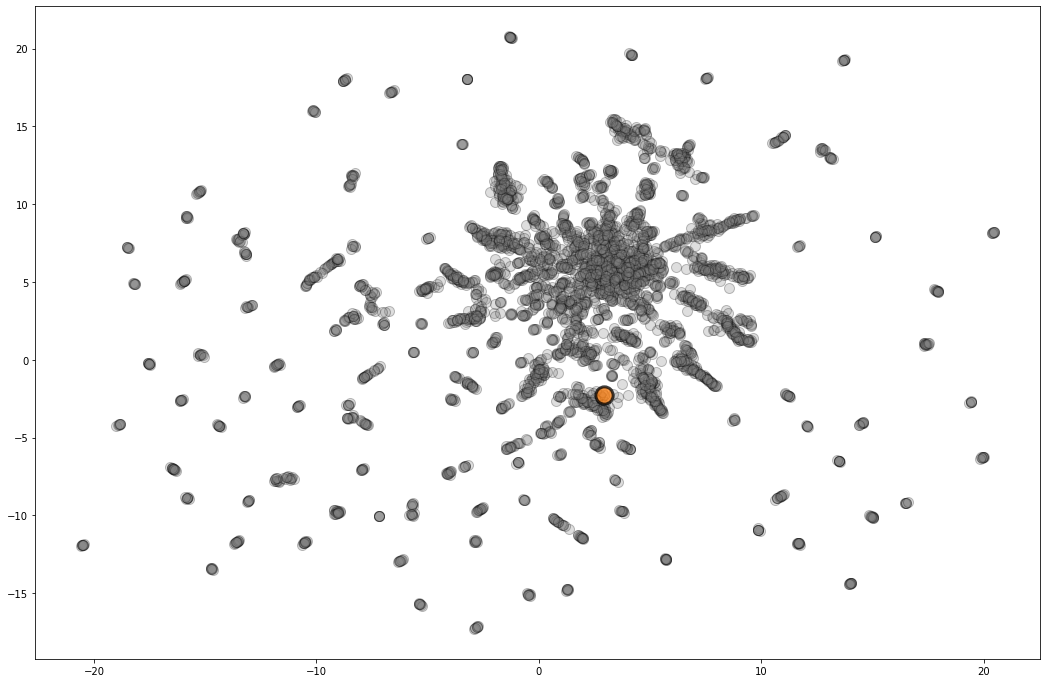

In [299]:
rvid = 'Rv2031c'
plt.figure(figsize=(18,12))
plt.scatter(vizdf.hUMAP_x, vizdf.hUMAP_y, s=100, color = colors[-3], edgecolors='k', alpha=0.25)
df_rvid = vizdf[vizdf.Rv_ID==rvid]
plt.scatter(df_rvid.hUMAP_x, df_rvid.hUMAP_y, s=300, color = colors[1], edgecolors='k', linewidths=3, alpha=0.75)

In [300]:
df_clus[df_clus.Rv_ID == rvid]

,hUMAP_x,hUMAP_y,Rv_ID,cluster_labels


11


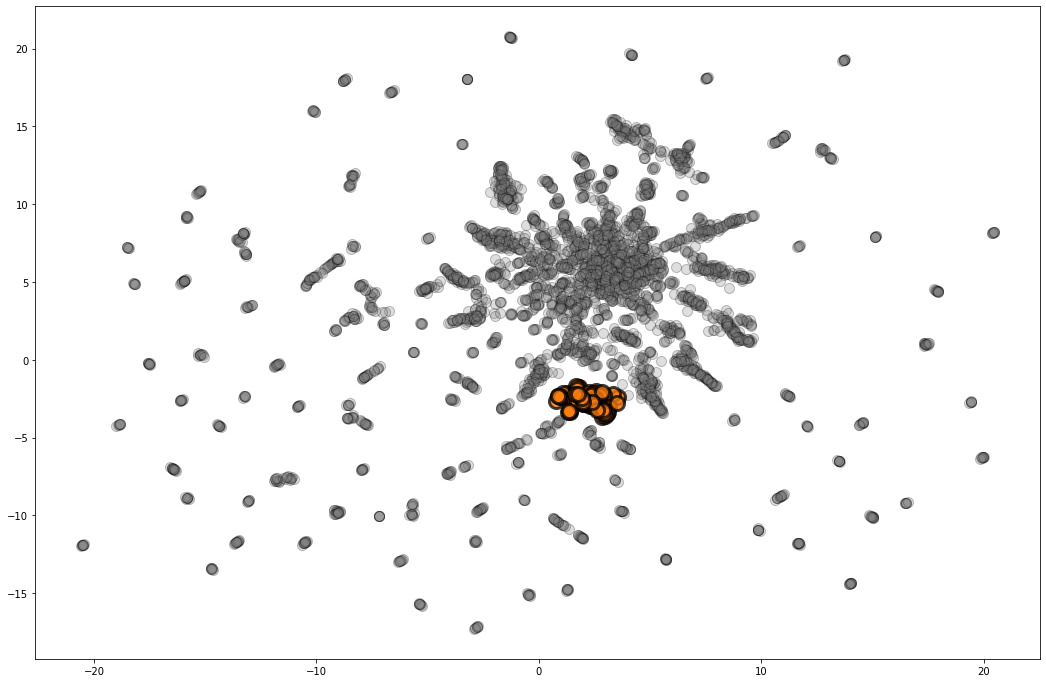

In [301]:
clus = df_rvid.cluster_labels.values[0]
print(clus)
plt.figure(figsize=(18,12))
plt.scatter(vizdf.hUMAP_x, vizdf.hUMAP_y, s=100, color = colors[-3], edgecolors='k', alpha=0.25)
df_clus = vizdf[vizdf.cluster_labels==clus]
plt.scatter(df_clus.hUMAP_x, df_clus.hUMAP_y, s=200, color = colors[1], edgecolors='k', linewidths=3, alpha=0.75)

In [295]:
cols = ['Rv_ID', 'Gene names', 'Protein names', 'Annotation', 'Function [CC]', 'Rhea ID', 'cluster_labels']

In [374]:
df_up_func[(df_up_func.cluster_labels == clus)].sort_values(by='annot_int', ascending = False)[cols].head(10)

,Rv_ID,Gene names,Protein names,Annotation,Function [CC],Rhea ID,cluster_labels
119,Rv0116c,ldtA Rv0116c RVBD_0116c P425_00122,"L,D-transpeptidase 1 (LDT 1) (EC 2.3.2.-) (Ldt...",5 out of 5,FUNCTION: Generates 3->3 cross-links in peptid...,NaN,11
1097,Rv1082,mca Rv1082,Mycothiol S-conjugate amidase (EC 3.5.1.115),5 out of 5,"FUNCTION: A mycothiol (MSH, N-acetyl-cysteinyl...",RHEA:36543,11
3373,Rv3372,otsB otsB2 Rv3372,Trehalose-phosphate phosphatase (TPP) (EC 3.1....,5 out of 5,FUNCTION: Removes the phosphate from trehalose...,RHEA:23420,11
3132,Rv3130c,tgs1 Rv3130c MTCY03A2.28 MTCY164.41c,Probable diacyglycerol O-acyltransferase tgs1 ...,5 out of 5,FUNCTION: Catalyzes the terminal and only comm...,RHEA:10868; RHEA:45780; RHEA:45781,11
2710,Rv2703,sigA mysA rpoD rpoV Rv2703 MTCY05A6.24,RNA polymerase sigma factor SigA (Sigma-A),5 out of 5,FUNCTION: Sigma factors are initiation factors...,NaN,11
2548,Rv2540c,aroC aroF Rv2540c MTCY159.16,Chorismate synthase (CS) (EC 4.2.3.5) (5-enolp...,5 out of 5,"FUNCTION: Catalyzes the anti-1,4-elimination o...",RHEA:21020,11
2546,Rv2538c,aroB Rv2538c MTCY159.18,3-dehydroquinate synthase (DHQS) (EC 4.2.3.4),5 out of 5,FUNCTION: Catalyzes the conversion of 3-deoxy-...,RHEA:21968,11
2369,Rv2361c,uppS Rv2361c MTCY27.19,Decaprenyl diphosphate synthase (DecaPP) (EC 2...,5 out of 5,FUNCTION: Catalyzes the sequential condensatio...,RHEA:47096; RHEA:53008,11
2278,Rv2266,cyp124 Rv2266 MTCY339.44c,Methyl-branched lipid omega-hydroxylase (EC 1....,5 out of 5,FUNCTION: Primarily hydroxylates the omega-car...,RHEA:49996; RHEA:43956; RHEA:43957; RHEA:43952...,11
2047,Rv2031c,hspX acr Rv2031c MTV018.18c,Alpha-crystallin (Acr) (14 kDa antigen) (16 kD...,5 out of 5,"FUNCTION: Acts as a chaperone, as it has a sig...",NaN,11


# NEXT CHALLENGE: Take linear combinations of the TnSeq and the Gene Expression graphs: 
